In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import random

#Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#sklearn modules
from scipy import stats
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error

#Time Series
import datetime
from datetime import datetime
from datetime import timedelta
from time import time

#Statsmodels
import statsmodels

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%dT%H:%M:%S.%fZ')

In [3]:
data = pd.read_csv("yieldsamurai_data_uniswapv2_USDCWETH.csv", parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [4]:
data['DAPR'] = data['DAPR'].str.rstrip('%').astype('float')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 715 entries, 2020-05-05 to 2022-04-19
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DAPR    715 non-null    float64
 1   TVL     715 non-null    object 
dtypes: float64(1), object(1)
memory usage: 16.8+ KB


In [6]:
data.head()

,DAPR,TVL
Date,,
2020-05-05,4.47,1.78
2020-05-06,0.10,1.98
2020-05-07,0.00,2
2020-05-08,0.00,3.06
2020-05-09,0.00,13.09


In [7]:
df = data.asfreq(pd.infer_freq(data.index))

In [8]:
DAPR_series = df.DAPR

In [9]:
DAPR_series

Date
2020-05-05     4.47
2020-05-06     0.10
2020-05-07     0.00
2020-05-08     0.00
2020-05-09     0.00
              ...  
2022-04-15     4.93
2022-04-16     3.19
2022-04-17    14.14
2022-04-18    14.33
2022-04-19    12.05
Freq: D, Name: DAPR, Length: 715, dtype: float64

# Time Series Pre-Processing

In [10]:
# Get the Peaks and Troughs
doublediff = np.diff(np.sign(np.diff(df.DAPR)))
peak_locations = np.where(doublediff == -2)[0] + 1

doublediff2 = np.diff(np.sign(np.diff(-1*df.DAPR)))
trough_locations = np.where(doublediff2 == -2)[0] + 1

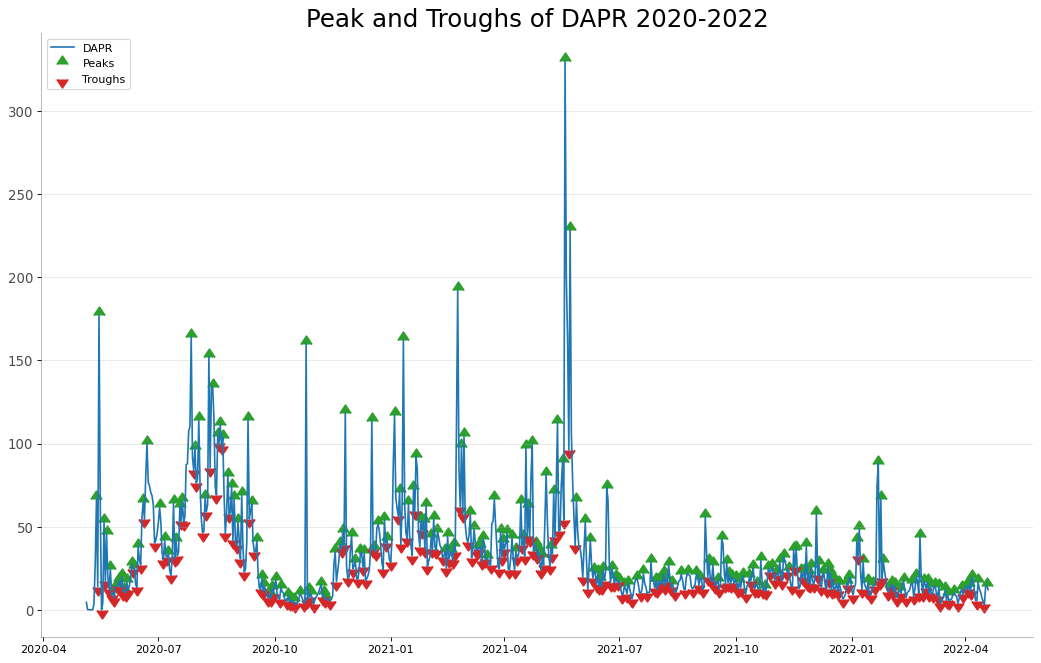

In [11]:
# Draw Plot
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(df.DAPR.index, 'DAPR', data=df, color='tab:blue', label='DAPR')
plt.scatter(df.index[peak_locations], df.DAPR[peak_locations], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Peaks')
plt.scatter(df.index[trough_locations], df.DAPR[trough_locations], marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Troughs')

# Decoration
plt.title("Peak and Troughs of DAPR 2020-2022", fontsize=22)
plt.yticks(fontsize=12, alpha=.7)

# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.3)

plt.legend(loc='upper left')
plt.grid(axis='y', alpha=.3)
plt.show()

In [12]:
def plot_series(series):
    plt.figure(figsize=(16,10), dpi=80)
    plt.plot(DAPR_series, color='red')
    plt.ylabel('DAPR %', fontsize=16)
        


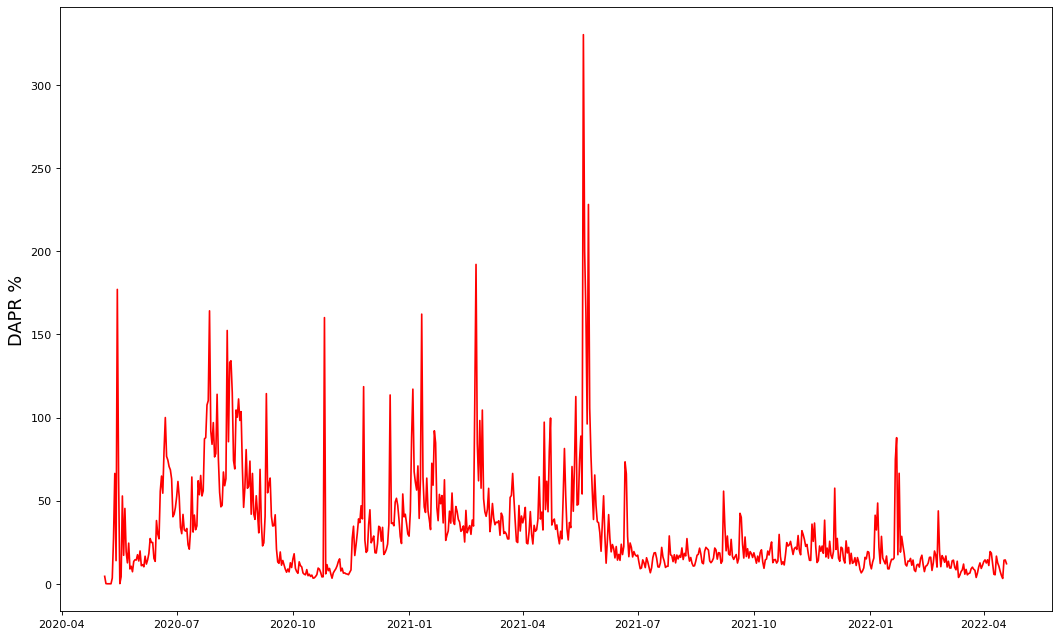

In [13]:
plot_series(DAPR_series)

## Normalize

In [14]:
avg, dev = DAPR_series.mean(), DAPR_series.std()

In [15]:
DAPR_series = (DAPR_series - avg) / dev

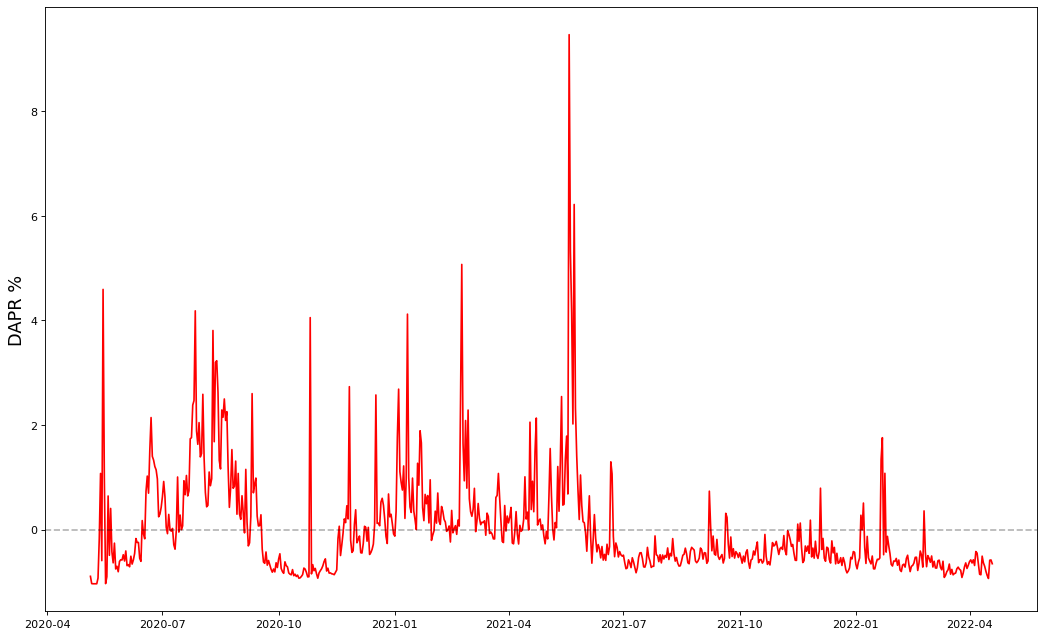

In [16]:
plot_series(DAPR_series)
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

## First Difference To Remove Trend

In [17]:
DAPR_series = DAPR_series.diff().dropna()

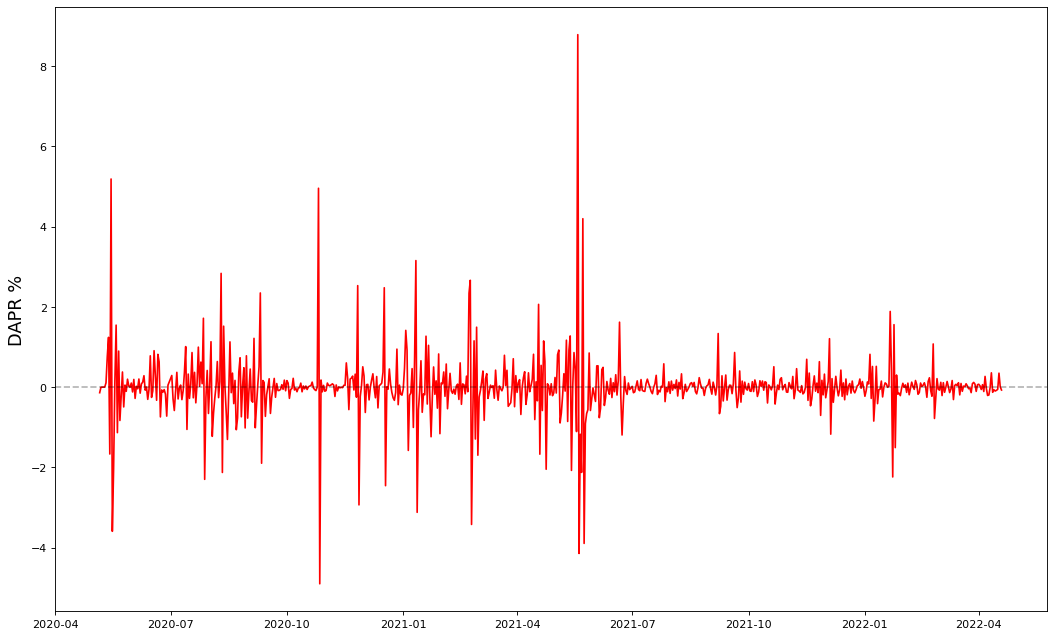

In [18]:
plot_series(DAPR_series)
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

## Remove Increasing Volatility (Daily)

In [19]:
daily_volatility = DAPR_series.groupby(DAPR_series.index.day).std()

In [20]:
    daily_volatility

Date
1     0.382910
2     0.344806
3     0.478210
4     0.474278
5     0.594067
6     0.352917
7     0.378371
8     0.337055
9     0.298329
10    0.787946
11    0.914575
12    0.782346
13    0.450139
14    0.615402
15    1.139933
16    0.800822
17    0.740076
18    0.777683
19    1.887141
20    0.947553
21    0.677367
22    0.829335
23    1.268740
24    1.246099
25    0.502314
26    1.201549
27    1.281627
28    0.664087
29    0.373380
30    0.384826
31    0.299398
Name: DAPR, dtype: float64

In [21]:
DAPR_daily_vol = DAPR_series.index.map(lambda d: daily_volatility.loc[d.day])

In [22]:
DAPR_daily_vol

Float64Index([ 0.3529170339859311, 0.37837143885350677,  0.3370554209707788,
               0.2983286809293465,  0.7879455929411777,  0.9145751540601432,
               0.7823456271635195,  0.4501394789226932,  0.6154018104797645,
                1.139933489040803,
              ...
               0.7879455929411777,  0.9145751540601432,  0.7823456271635195,
               0.4501394789226932,  0.6154018104797645,   1.139933489040803,
               0.8008217922750341,  0.7400758286600388,  0.7776829868855643,
               1.8871414897555927],
             dtype='float64', name='Date', length=714)

In [23]:
DAPR_series = DAPR_series / DAPR_daily_vol

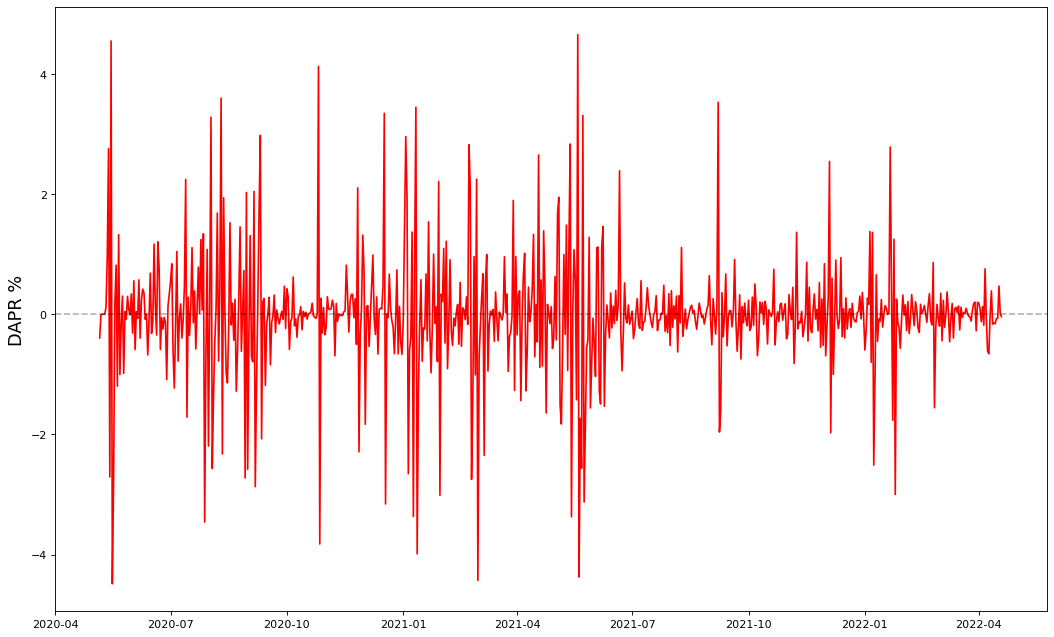

In [24]:
plot_series(DAPR_series)
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

## Remove Seasonality (Weekly)

In [25]:
weekly_avgs = DAPR_series.groupby(DAPR_series.index.week).mean()

C:\Users\Jax\AppData\Local\Temp/ipykernel_16472/3611673579.py:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  weekly_avgs = DAPR_series.groupby(DAPR_series.index.week).mean()


In [26]:
weekly_avgs

Date
1    -0.277815
2    -0.168986
3     0.132795
4    -0.199269
5     0.133135
6    -0.100696
7     0.043398
8     0.160571
9    -0.467020
10   -0.048433
11   -0.008782
12   -0.021952
13    0.069586
14   -0.042830
15    0.263887
16   -0.087588
17   -0.107906
18    0.057745
19    0.155708
20   -0.219806
21   -0.482404
22   -0.175351
23    0.015810
24    0.051976
25    0.256194
26   -0.147052
27   -0.020950
28    0.049425
29    0.103147
30    0.151882
31   -0.055298
32   -0.186438
33    0.065204
34   -0.035384
35    0.092731
36   -0.272826
37    0.150450
38   -0.170363
39   -0.046407
40    0.000020
41   -0.013158
42    0.001089
43    0.003202
44   -0.058261
45    0.038712
46    0.030287
47    0.146122
48   -0.032027
49   -0.006691
50    0.076016
51    0.040789
52    0.010275
53    0.366705
dtype: float64

In [27]:
DAPR_weekly_avg = DAPR_series.index.map(lambda d: weekly_avgs.loc[d.week])

C:\Users\Jax\AppData\Local\Temp/ipykernel_16472/4163458114.py:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  DAPR_weekly_avg = DAPR_series.index.map(lambda d: weekly_avgs.loc[d.week])


In [28]:
DAPR_weekly_avg

Float64Index([ 0.15570798232137298,  0.15570798232137298,  0.15570798232137298,
               0.15570798232137298,  0.15570798232137298,  -0.2198063171964255,
               -0.2198063171964255,  -0.2198063171964255,  -0.2198063171964255,
               -0.2198063171964255,
              ...
              -0.04282950837780929,   0.2638868442800611,   0.2638868442800611,
                0.2638868442800611,   0.2638868442800611,   0.2638868442800611,
                0.2638868442800611,   0.2638868442800611,  -0.0875881483302784,
               -0.0875881483302784],
             dtype='float64', name='Date', length=714)

In [29]:
DAPR_series = DAPR_series - DAPR_weekly_avg

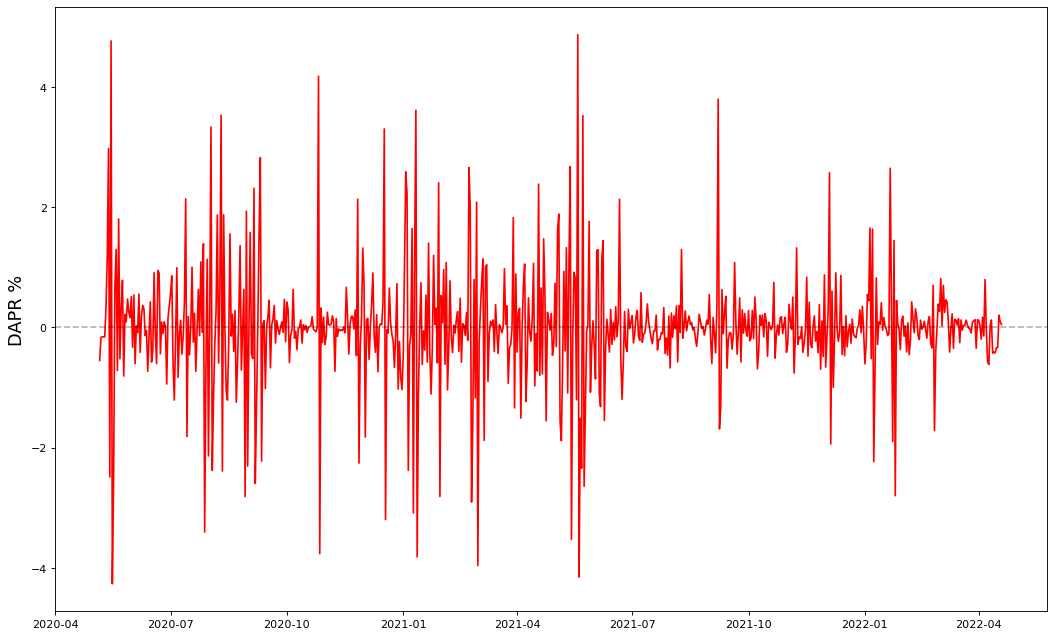

In [30]:
plot_series(DAPR_series)
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

## Checking Stationarity (ADF Test)

In [31]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [32]:
#check stationarity
perform_adf_test(DAPR_series)

ADF Statistic: -10.098960
p-value: 0.000000


# ARIMA Modeling

## ACF Plot

C:\Users\Jax\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\Jax\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


<BarContainer object of 20 artists>

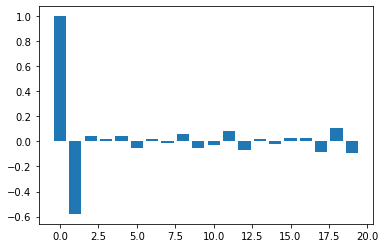

In [33]:
first_diff = DAPR_series.diff()[1:]
acf_vals = acf(first_diff)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

## PACF

C:\Users\Jax\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\Jax\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


<BarContainer object of 15 artists>

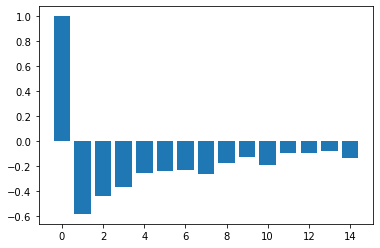

In [34]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

## Training/Test Sets

In [35]:
train_end = datetime(2021,5,1)
test_end = datetime(2022,4,19)

train_data = DAPR_series[:train_end]
test_data = DAPR_series[train_end + timedelta(days=1):test_end]

In [36]:
datetime.now()

datetime.datetime(2022, 4, 27, 20, 21, 46, 844530)

## Fit ARIMA Model

In [37]:
my_order = (0,1,0) # in order of p (PACF), d (difference), q (ACF)
my_seasonal_order = (1, 0, 1, 12) 
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [38]:
#fit the model
start = time()
model_fit = model.fit(disp=0)
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.41187262535095215


In [39]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  361
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -732.151
Date:                              Wed, 27 Apr 2022   AIC                           1470.303
Time:                                      20:21:47   BIC                           1481.961
Sample:                                  05-06-2020   HQIC                          1474.938
                                       - 05-01-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.7836      0.191      4.110      0.000       0.410       1.157
ma.S.L12      -0.86

In [40]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

Text(0, 0.5, 'Error')

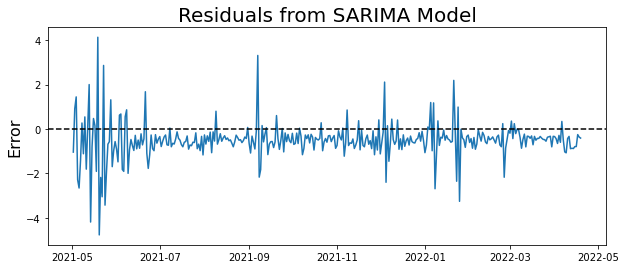

In [41]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

### Evaluation 

In [42]:
# Accuracy metrics
mape = np.mean(np.abs(predictions - test_data)/np.abs(test_data))
mae = np.mean(np.abs(predictions - test_data))

print(f'MAPE = {mape}, MAE = {mae}')

MAPE = 5.648792223979458, MAE = 0.7107709713546767


## Fit ARIMA Model

In [43]:
#create the model
model = ARIMA(train_data, order=(2,1,2))

In [44]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.5128638744354248


In [45]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  361
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -516.358
Date:                Wed, 27 Apr 2022   AIC                           1042.716
Time:                        20:21:48   BIC                           1062.147
Sample:                    05-06-2020   HQIC                          1050.442
                         - 05-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3631      0.056      6.470      0.000       0.253       0.473
ar.L2          0.0375      0.043      0.882      0.378      -0.046       0.121
ma.L1         -1.8740      0.039    -48.068      0.0

In [46]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

Text(0, 0.5, 'Error')

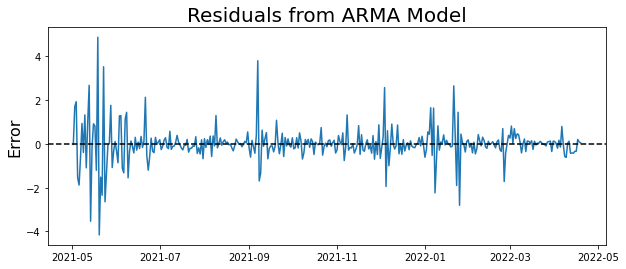

In [47]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from ARMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

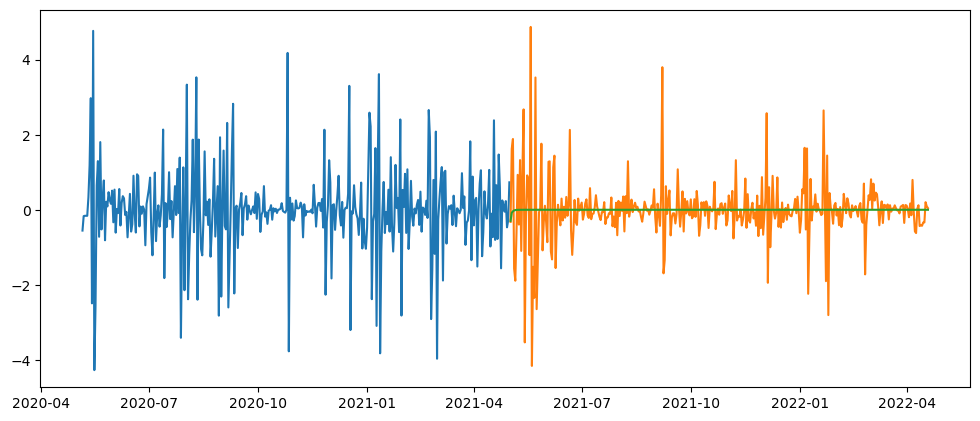

In [49]:
# Plot Actual vs forecasted
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='Training')
plt.plot(test_data, label='Actual')
plt.plot(predictions, label='Forecasted')

In [50]:
# Accuracy Metrics
mape = np.mean(np.abs(predictions - test_data)/np.abs(test_data))
mae = np.mean(np.abs(predictions - test_data))

print(f'MAPE = {mape}, MAE = {mae}')

MAPE = 0.9979497610429441, MAE = 0.4612972789256018
